Кейс: a/b-тест для мобильного приложения.

Имеется мобильное приложение для магазина по продаже продуктов питания. Выдвинута гипотеза о том, что смена шрифтов улучшит качество обслуживания по количеству клиентов, совершающих каждое событие. Для проверки этой гипотезы принято решение провести A/B-тест.   

Договорились принять решение по результатам A/B-теста.
Пользователей разбили на 2 группы: 247 -- контрольная группа со старыми шрифтами; 248 -- экспериментальная с новыми шрифтами.

Описание данных

|Признак|Комментарий|
|--:|:--|
|`EventName`|название события|
|`DeviceIDHash`|уникальный идентификатор пользователя|
|`EventTimestamp`|время события|
|`ExpId`|номер группы|

Инструкция по выполнению проекта

Шаг 1. Загрузите данные
- Знакомство с данными;
- Корректность a/b-теста.

Шаг 2. Подготовьте данные
- Корректировка заголовков;
- Типы данных;
- Аномалии пропуски.

Шаг 3. EDA
- Cколько всего событий?
- Сколько всего пользователей в логе?
- Сколько в среднем событий приходится на пользователя?
- Период теста: максимальная и минимальная даты; гистограмма по дате и количеству событий.

Шаг 4. Анализ воронки событий
- Распределение событий: какие события и в каком количестве.
- Сколько пользователей совершали каждое из этих событий?
- Постройте воронку событий: какая доля пользователей проходит на следующий шаг воронки. На каком шаге теряете больше всего пользователей?
Какая доля пользователей доходит от первого события до оплаты?

Шаг 5. Анализ результатов эксперимента
- Сколько пользователей в каждой группе?
- Посчитайте долю пользователей, совершивших каждое из событий.
- Проверьте гипотезу о наличие значимых отличий по результатам теста.

С помощью Yandex DataLens создайте дашборд, отвечащий на следующие вопросы:
- сколько уникальных клиентов в группах 247 и 248;
- сколько уникальных клиентов совершили события по каждой группе;
- по каждой группе построить распределение количества событий по времени.

Ссылку на дашборд прикрепите к настоящей тетради.

In [137]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [16]:
# Шаг 1. Загрузите данные
# Знакомство с данными;
df = pd.read_csv('./ab_testing.csv',  sep='\x09')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [26]:
# Корректность a/b-теста.
# Проверка на членство одного Id в нескольких группах
devIdDict = {grname: set(dfg) for grname,dfg in df.groupby('ExpId')['DeviceIDHash']}
keys = list(devIdDict.keys())
for i,gr0 in enumerate(keys):
    for gr1 in keys[i+1:]:
        print('ExpId[%d]&ExpId[%d] =='%(gr0, gr1), devIdDict[gr0] & devIdDict[gr1])

ExpId[246]&ExpId[247] == set()
ExpId[246]&ExpId[248] == set()
ExpId[247]&ExpId[248] == set()


In [207]:
# Шаг 2. Подготовьте данные
# Корректировка заголовков;
headertext="""|`EventName`|название события|
|`DeviceIDHash`|уникальный идентификатор пользователя|
|`EventTimestamp`|время события|
|`ExpId`|номер группы|"""
re_extract_header = re.compile(r'\s*[|][`]([\w\s]+)[`][|]([\w\s]+)[|]')
header_translate_dict = dict(map(lambda x: re_extract_header.fullmatch(x).groups(), headertext.split('\n')))
invert = lambda d: dict(map(reversed, d.items()))
dth = header_translate_dict

re_valid_python_identifier = re.compile(r'[\w_][\w\d\_]*')
if all(map(re_valid_python_identifier.fullmatch, df.columns)):
    print('Все заголовки являются верными идентификаторами Python')

Все заголовки являются верными идентификаторами Python


In [208]:
# Типы данных;
df['EventTimestamp'] = pd.to_datetime(df['EventTimestamp'], unit='s')  # изменяет df
# print(df['EventName'].unique())
event_dtype = pd.CategoricalDtype(['Tutorial','MainScreenAppear','OffersScreenAppear',
                                   'CartScreenAppear','PaymentScreenSuccessful'], ordered=True)
df['EventName'] = df['EventName'].astype(event_dtype)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   EventName       244126 non-null  category      
 1   DeviceIDHash    244126 non-null  int64         
 2   EventTimestamp  244126 non-null  datetime64[ns]
 3   ExpId           244126 non-null  int64         
dtypes: category(1), datetime64[ns](1), int64(2)
memory usage: 5.8 MB


In [209]:
# Аномалии пропуски.
# повторы
# df[df.duplicated(keep=False)].sort_values('DeviceIDHash').head(20)  # вероятно повторные события
sz, dupes = df.index.size, df.duplicated().sum()
print('Дубликаты (%d) составляют %.2f%% от общего числа записей (%d)' % (dupes, 100*dupes/sz, sz))
df2 = df.drop_duplicates()
print('Дубликаты удалены')

if df2.isna().sum().sum() == 0:
    print('Пропуски отсутствуют')

Дубликаты (413) составляют 0.17% от общего числа записей (244126)
Дубликаты удалены
Пропуски отсутствуют


Всего клиентов: 7551
Всего событий: 243713
Среднее число событий на пользователя: 32.27559263673685
Медианное число событий на пользователя: 20.0


,счёт,% от всех пользователей,% от всех событий,верхний предел
whisker,494,6.542180,33.348242,79
median 98%,76,1.006489,14.106757,199


DeviceIDHash
6304868067479728361    2307
197027893265565660     1998
4623191541214045580    1768
6932517045703054087    1439
1754140665440434215    1221
3337471580007169353    1186
7738058666231999878     888
1055544042902443290     854
4713748699910253089     824
8118046800480174342     755
dtype: int64

Отсеяно 76 клиентов (35372 событий)


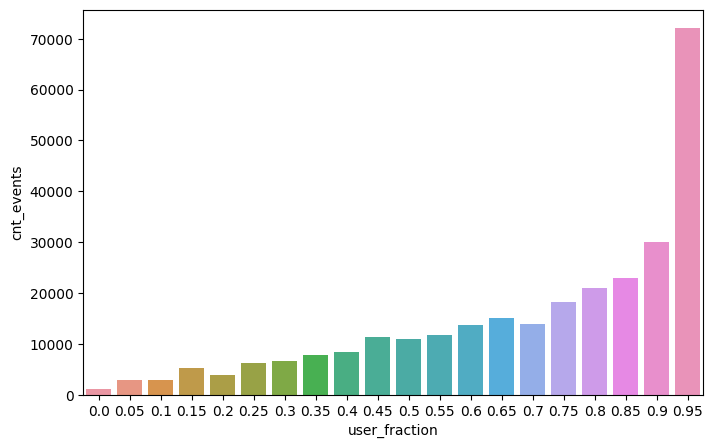

In [210]:
# Аномалии
def whisker_filter(series):
    k = 1.5
    high, low = series.quantile(.75), series.quantile(.25)
    iqr = high -low
    high, low = high +k*iqr, low -k*iqr
    return ~series.between(low, high, 'both')

def median_filter(series, fraction):
    high, low = series.quantile(.5 +fraction/2), series.quantile(.5 -fraction/2)
    return ~series.between(low, high, 'both')


df_user_activity = df2.groupby('DeviceIDHash').size()
print('Всего клиентов:', df_user_activity.size)
print('Всего событий:', df_user_activity.sum())
print('Среднее число событий на пользователя:', df_user_activity.mean())
print('Медианное число событий на пользователя:', df_user_activity.median())

anomalies = [whisker_filter(df_user_activity), median_filter(df_user_activity, fraction=.98)]

display(pd.DataFrame({'счёт': map(sum, anomalies), 
                      '% от всех пользователей': map(lambda x: 100*x.sum()/x.size, anomalies),
                      '% от всех событий': map(lambda x: 100*df_user_activity[x].sum()/df_user_activity.sum(), anomalies),
                      'верхний предел': map(lambda x: df_user_activity[~x].max(), anomalies)}, 
                     index=['whisker', 'median 98%']))
display(df_user_activity[anomalies_whisker].sort_values(ascending=False).head(10))

plt.figure(figsize=(8, 5))
# sns.histplot(df_user_activity, stat='count')

barcnt = 20
bardata = dict()
for i in range(barcnt):
    high, low = df_user_activity.quantile((i+1)/barcnt), df_user_activity.quantile(i/barcnt)
    bardata[i/barcnt] = df_user_activity[df_user_activity.between(low, high)].sum()
sns.barplot(pd.DataFrame({'cnt_events':bardata.values(), 'user_fraction':bardata.keys()}), 
            x='user_fraction', y='cnt_events')

anomalous_ids = set(df_user_activity.index[median_filter(df_user_activity, fraction=.98)])
df3 = df2[~df2['DeviceIDHash'].isin(anomalous_ids)]    # Удалить подозрительно активных
df3 = df3[df3['EventName'] != 'Tutorial']              # Удалить ненужный класс событий
print('\x1b[0;31;40mОтсеяно %d клиентов (%d событий)\x1b[0m' % (len(anomalous_ids), df2.index.size-df3.index.size))

Всего 208341 событий
Всего 7471 пользователей
В среднем на пользователя приходится 27.886628 событий
Минимальная дата: 25/07/'19
Максимальная дата: 07/08/'19
отсеяно 2707 событий до начала теста


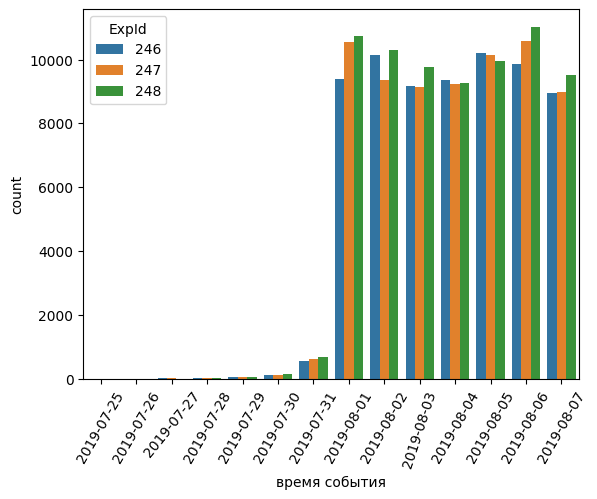

In [211]:
# Шаг 3. EDA
# Cколько всего событий?
print('Всего %d событий' % df3.index.size)

# Сколько всего пользователей в логе?
print('Всего %d пользователей' % df3['DeviceIDHash'].nunique())

# Сколько в среднем событий приходится на пользователя?
print('В среднем на пользователя приходится %f событий' % df3.groupby('DeviceIDHash').size().mean())

# Период теста: максимальная и минимальная даты; 
fmt_spec = r"%d/%m/'%y"
print('Минимальная дата: %s' % df3['EventTimestamp'].min().strftime(fmt_spec))
print('Максимальная дата: %s' % df3['EventTimestamp'].max().strftime(fmt_spec))

#гистограмма по дате и количеству событий.
df_activity_by_date = df3.groupby([df3['EventTimestamp'].dt.date, 'ExpId']).size().rename('count').reset_index()
# display(df_activity_by_date)
ax = sns.barplot(df_activity_by_date, x='EventTimestamp', y='count', hue='ExpId')
for i,lbl in enumerate(ax.get_xticklabels()):
    if i not in[2,9]: lbl.set_rotation(60)
    else: lbl.set_rotation(45+3*i)  # ;)
ax.set_xlabel(dth[ax.get_xlabel()])

df4 = df3[df3['EventTimestamp'] >= pd.Timestamp('2019-08-01')]
print('отсеяно %d событий до начала теста' % (df3.index.size-df4.index.size))

какие события и в каком количестве:


ExpId,246,247,248
EventName,,,
MainScreenAppear,36082,37835,39347
OffersScreenAppear,13267,13516,14173
CartScreenAppear,10082,9415,9753
PaymentScreenSuccessful,7676,7199,7289


Сколько пользователей совершали каждое из этих событий:


ExpId,246,247,248
EventName,,,
MainScreenAppear,2423,2454,2467
OffersScreenAppear,1514,1498,1505
CartScreenAppear,1238,1216,1204
PaymentScreenSuccessful,1172,1136,1155


какая доля пользователей проходит на следующий шаг воронки:


,246,247,248
Main->Offers,0.624845,0.610432,0.610053
Offers->Cart,0.817701,0.811749,0.800000
Cart->Payment,0.946688,0.934211,0.959302


На каком шаге теряете больше всего пользователей:


,246,247,248
<lambda>,Main->Offers,Main->Offers,Main->Offers


Какая доля пользователей доходит от первого события до оплаты:


,246,247,248
<lambda>,0.483698,0.462918,0.46818


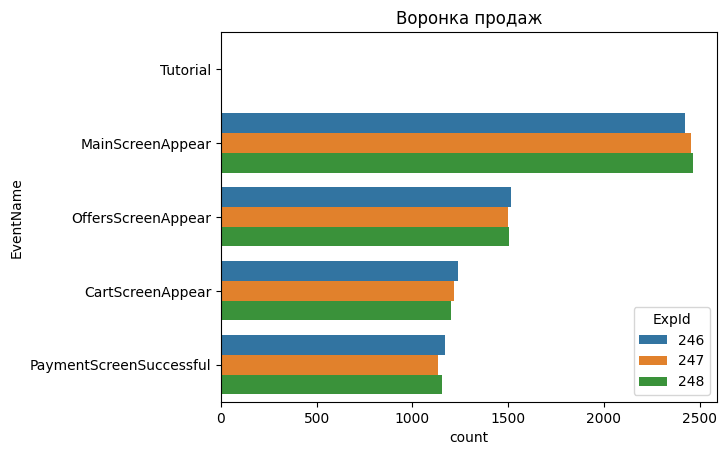

In [257]:
# Шаг 4. Анализ воронки событий
# Распределение событий: какие события и в каком количестве.
df_evt_distr = df4.groupby(['EventName', 'ExpId'], observed=True) \
                  .agg(unique_users=('DeviceIDHash', 'nunique'),
                       events=('DeviceIDHash', 'size')).unstack()#.reset_index()
print('какие события и в каком количестве:')
display(df_evt_distr['events'])

# Сколько пользователей совершали каждое из этих событий?
unique_users = df_evt_distr['unique_users']
print('Сколько пользователей совершали каждое из этих событий:')
display(unique_users)

# Постройте воронку событий: какая доля пользователей проходит на следующий шаг воронки. 
sns.barplot(unique_users.stack().reset_index().rename(columns={0:'count'}), y='EventName', x='count', hue='ExpId')
plt.title('Воронка продаж')

dict_conversion = dict()
for k,d in unique_users.items():
    d = list(d)
    dict_conversion[k] = [r/l for l,r in zip(d[:-1], d[1:])]
print('какая доля пользователей проходит на следующий шаг воронки:')
df_conv = pd.DataFrame(dict_conversion, 
                       index=map('->'.join, (lambda l: zip(l[:-1], l[1:]))(list(map(lambda x: x.split('S')[0], unique_users.index)))) )
display(df_conv)

# На каком шаге теряете больше всего пользователей? Какая доля пользователей доходит от первого события до оплаты?
print('На каком шаге теряете больше всего пользователей:')
display(df_conv.agg([lambda s: s.index[s.argmin()]]))

print('Какая доля пользователей доходит от первого события до оплаты:')
display(df_conv.agg([lambda s: s.product()]))

In [267]:
# Шаг 5. Анализ результатов эксперимента
# Сколько пользователей в каждой группе?
print('Сколько пользователей в каждой группе:')
display(df4.groupby('ExpId')['DeviceIDHash'].agg(['nunique']))

# Посчитайте долю пользователей, совершивших каждое из событий.
print('доли пользователей, совершивших каждое из событий:')
display(df4.groupby(['EventName', 'ExpId'], observed=True)['DeviceIDHash'].agg('nunique').unstack().transform(lambda s: s/s.max()))

# Проверьте гипотезу о наличие значимых отличий по результатам теста.


Сколько пользователей в каждой группе:


,nunique
ExpId,
246,2455
247,2490
248,2509


доли пользователей, совершивших каждое из событий:


ExpId,246,247,248
EventName,,,
MainScreenAppear,1.000000,1.000000,1.000000
OffersScreenAppear,0.624845,0.610432,0.610053
CartScreenAppear,0.510937,0.495518,0.488042
PaymentScreenSuccessful,0.483698,0.462918,0.468180
